In [135]:
import numpy as np
from scipy.sparse import csr_matrix, diags
import networkx as nx
import random 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [86]:
n=30
#G=nx.scale_free_graph(n, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, seed=None, initial_graph=None)
#G=nx.scale_free_graph(n, alpha=0.8, beta=0.1, gamma=0.1, delta_in=0.2, delta_out=0, seed=None, initial_graph=None)
G=nx.erdos_renyi_graph(n,0.5)

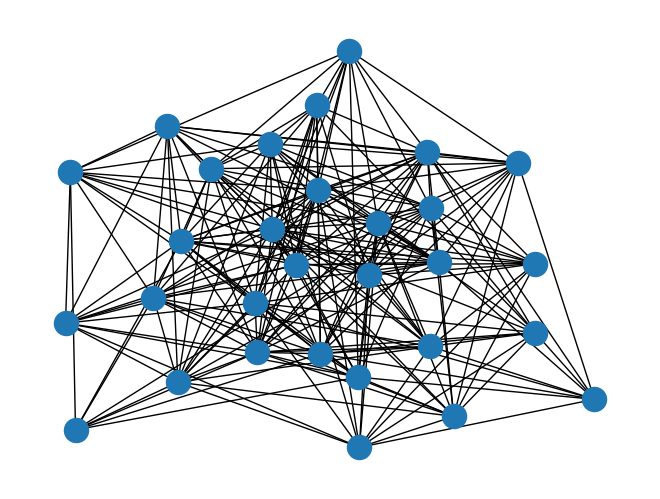

In [87]:
nx.draw(G)

In [92]:
def prune_graphlinks(netw):
    while True :
        l=[]
        #print(netw.number_of_nodes())
        for i in netw.nodes():
            if netw.degree[i]<=1:
                l.append(i)
        assert (netw.inflow not in l) and (netw.outflow not in l) 
        if l:
            #print(l)
            netw.remove_nodes_from(l)
        else:
            break

def get_flow(netw):
    """
    Returns the matrix of fluxes M and flow potentials F.
    
    An alternative of the following code is to compute the Laplacian matrix
    using the built-in L = laplacian(G) function. However, for small networks
    (i.e. N0 < 1600), this code seems faster.
    (need further investigations for assessing runtime differences).
    """
    prune_graphlinks(netw)
    
    
    # Preallocs:
    #sized = netw.graph.Nodes.shape[0]
    sized = netw.number_of_nodes()
    
    # For Matlab 'graph' adaptation, just re-create the adjacency matrix:
    netw.adjm = nx.adjacency_matrix(netw).todense()
    netw.adjm[netw.adjm > 1] = 1
    
    
    # Use Python version:
    P, S = prepare_linsys(netw, sized)
    
    # Remove both inflow and outflow entries from P:
    #P = np.delete(np.delete(P, netw.inflow, 0), netw.inflow, 1)
    P = np.delete(np.delete(P, netw.outflow, 0), netw.outflow, 1)
    #S = np.delete(S, [netw.inflow, netw.outflow])
    S = np.delete(S, [netw.outflow])
    
    # Solve the linear system:
    FF = np.linalg.solve(P, S)
    # Re-insert inflow and outflow nodes:
    F = np.zeros(sized)
    #F[:min([netw.inflow, netw.outflow])-1] = FF[:min([netw.inflow, netw.outflow])-1]
    #F[min([netw.inflow, netw.outflow])+1:max([netw.inflow, netw.outflow])-1] = FF[min([netw.inflow, netw.outflow]):max([netw.inflow, netw.outflow])-2]
    #F[max([netw.inflow, netw.outflow])+1:] = FF[max([netw.inflow, netw.outflow])-1:]
    F[1:]=FF[:]
    
    
    if min([netw.inflow, netw.outflow]) == netw.inflow:
        F[min([netw.inflow, netw.outflow])] = 1
        F[max([netw.inflow, netw.outflow])] = 0
    else:
        F[min([netw.inflow, netw.outflow])] = 0
        F[max([netw.inflow, netw.outflow])] = 1
    
    F = F.T
    
    # Then compute the fluxes matrix M, according to F (flow potentials):
    M = compute_q(netw, sized, F)
    
    return F, M

def compute_q(netw, sized, F):
    """
    Compute the fluxes matrix M, according to F (flow potentials).
    """
    M = np.zeros((sized, sized))
    
    for i in range(netw.adjm.shape[0]):
        #idx = netw.adjm[i] == 1
        idx = [j for j in range(sized) if netw.adjm[i,j] == 1]
        #D = netw.dis_eucl[i, idx]
        D=1
        for j in idx:
             M[i, j] = -(F[i] - F[j]) / D

    return M

def prepare_linsys(netw, sized):
    """
    Prepare the linear system for solving.
    """
    P = np.zeros((sized, sized))
    S = np.zeros(sized)
    nodes = list(netw.nodes())
    for i in range(netw.adjm.shape[0]):
        idx = [j for j in range(sized) if netw.adjm[i,j] == 1]
        
        for j in idx:
            P[i,j] = -1
        
        P[i,i]=len(idx)
     
    S[nodes.index(netw.inflow)]=1

    return P, S



In [150]:
def gen_graph(n):
    G=nx.erdos_renyi_graph(n,0.5)
    G.inflow=1
    G.outflow=0
    
    #G=nx.scale_free_graph(n, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, seed=None, initial_graph=None)
    #G2 = G.to_undirected()
    #G2.remove_edges_from(nx.selfloop_edges(G2))
    
    return G
    #return G2


def get_Q(netw):
    [F,M]=get_flow(netw)
    (idxi,idxj)=np.where(M==np.min(np.abs(M[np.nonzero(M)])))
    return np.abs(M[1].sum()) , (idxi[0],idxj[0])


In [137]:
G=gen_graph(n)
print(get_Q(G))

17.94346556267092


In [151]:
get_Q(G)

(17.94346556267092, (25, 9))

In [138]:
[F,M]=get_flow(G)

In [145]:
#np.min(np.abs(M[np.nonzero(M)]))
np.where(M==np.min(np.abs(M[np.nonzero(M)])))

(array([25]), array([9]))

In [146]:
M[25,9]

1.1355931372927786e-05

In [149]:
np.min(np.abs(M[np.nonzero(M)]))

1.1355931372927786e-05

In [155]:
def delete_random_edge(graph):
    edges = list(graph.edges)

    # random edge choice
    chosen_edge = random.choice(edges)
    graph.remove_edge(chosen_edge[0], chosen_edge[1])

    return graph

def delete_weakest_link(graph,chosen_edge):
    nodes = list(graph.nodes())
    graph.remove_edge(nodes[chosen_edge[0]], nodes[chosen_edge[1]])
    return graph

100%|███████████████████████████████████████████| 20/20 [01:19<00:00,  3.97s/it]


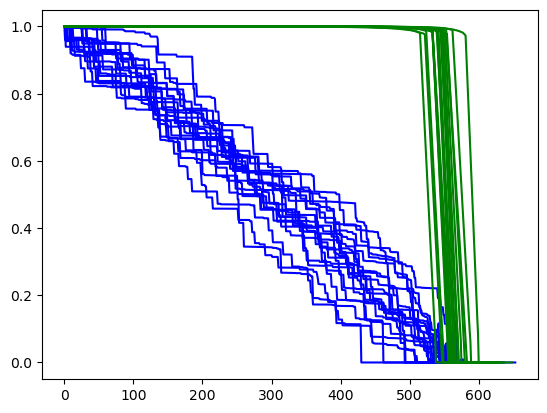

In [157]:
n=50
n_exp=20

for k in tqdm(range(n_exp)):

    G=gen_graph(n)
    loop_size = len(G.edges) 
    qs=np.zeros(loop_size)

    for i in range(loop_size):
        try:
            qs[i],chosenedge=get_Q(G)
        except:
            break
        delete_random_edge(G)

    plt.plot(qs/qs[0],'b-')
    
for k in tqdm(range(n_exp)):

    G=gen_graph(n)
    loop_size = len(G.edges) 
    qs=np.zeros(loop_size)

    for i in range(loop_size):
        try:
            qs[i],chosenedge=get_Q(G)
        except:
            break
        delete_weakest_link(G,chosenedge)

    plt.plot(qs/qs[0],'g-')

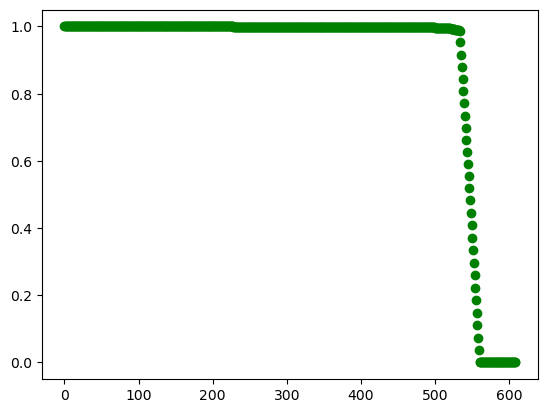

In [159]:
plt.plot(qs/qs[0],'go')